In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# ***Initial Data import: RNA-seq, HRD scores, BRCA annotations***

In [20]:
# Load the FPKM RNA-seq data
fpkm = pd.read_csv('data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
rnaseq_df = fpkm
# rnaseq_df = pd.read_csv("data/Deconvo2.csv", sep = ',', index_col=0)
# tpm = pd.read_csv('data/tpm.csv', sep=',', index_col=0)
# rnaseq_df = tpm
print(rnaseq_df.shape)
# Load the HRD score data
hrd_df = pd.read_excel('data/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('data/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')



(1231, 60663)


In [21]:
print(f"Initial samples in RNA-seq data (n = {len(rnaseq_df.index)}) \n\nInitial samples in TCGA BRCA (n = {len(brca_df.index)})\n\nInitial samples in TCGA HRD (n = {len(hrd_df.index)})\n\n")

Initial samples in RNA-seq data (n = 1231) 

Initial samples in TCGA BRCA (n = 992)

Initial samples in TCGA HRD (n = 9604)




# ***Drop ambiguouse/ mislabled samples***

In [22]:
# Drop rows where event.BRCA1 is '1' and event.BRCA2 is 'Bi-allelic-undetermined' and where event.PALB2 is '2'
brca_filt = brca_df[(brca_df['event.BRCA1'] != '1') & (brca_df['event.BRCA2'] != 'Bi-allelic-undetermined') & (brca_df['event.PALB2'] != '2')]
brca_filt.shape

(984, 33)

# ***Merge metadata***

In [23]:
#merge metadata

metadata = pd.merge(hrd_df, brca_filt, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)
print(metadata.columns)
metadata.head()

(859, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,H2.norm,H3.norm,H4.norm,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,0,0,0,0,0,0,0,0,0,0,...,0.044837,0.635070,0.000000,0,0,0,0,0,NaN,0
TCGA-A1-A0SD,10,10,7,27,0,0,0,0,0,0,...,0.254169,0.703974,0.041857,0,0,0,0,0,LumA,0
TCGA-A1-A0SE,6,6,1,13,0,0,0,0,0,0,...,0.102998,0.740053,0.120368,0,0,0,0,0,LumA,0
TCGA-A1-A0SF,7,11,8,26,0,0,0,0,0,0,...,0.000000,0.395329,0.604671,0,0,0,0,0,LumA,0
TCGA-A1-A0SG,3,2,4,9,0,0,0,0,0,0,...,0.183277,0.776319,0.040404,0,0,0,0,0,LumA,0


# Keep Protein coding columns + extracting gene IDs
## filter only Primary Tumor Samples

In [24]:
rnaseq_df.shape

(1231, 60663)

In [25]:
#rnaseq_df

In [26]:
#filt protein coding only
columns_to_keep = ['Case ID', 'Sample ID', 'Sample Type']
# columns_to_keep =[]
gene_columns = [col for col in rnaseq_df.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
pcg_rnaseq_df_filtered = rnaseq_df[final_columns]

#filt only primary tumor
pcg_rnaseq_df_filtered = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered['Sample Type'] == 'Primary Tumor']
print(pcg_rnaseq_df_filtered.shape)
#Slicing gene names
# split 0 for enseble ID, 1 for gene ID
#sliced_cols = [col.split('|')[1] for col in pcg_rnaseq_df_filtered.columns[3:]]
sliced_cols = [col.split('|')[1] for col in pcg_rnaseq_df_filtered.columns[3:]]

pcg_rnaseq_df_filtered.columns = columns_to_keep+sliced_cols
pcg_rnaseq_df_filtered.set_index('Case ID', inplace=True)


(1111, 19965)


In [27]:
pcg_rnaseq_df_filtered.shape

(1111, 19964)

# ***Get Intersecting samples***

In [28]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(pcg_rnaseq_df_filtered.index)
metadata_samples = set(metadata.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(metadata_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))


Number of common samples: 857


In [37]:
# Drop samples that are not common in all three dataframes
gene_expression = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered.index.isin(common_samples)]
labels = metadata[metadata.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("pcg_rnaseq_df_filtered:", gene_expression.shape)
print("metadata_common:", labels.shape)

pcg_rnaseq_df_filtered: (857, 19964)
metadata_common: (857, 37)


In [38]:
gene_expression = gene_expression.drop(columns=['Sample ID', 'Sample Type'])

In [39]:
gene_expression

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ACTL10,AC119733.1,AC020765.6,AC010980.1,AC004233.4,AL451106.1,AC008763.4,AC006486.3,AL391628.1,AP006621.6
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-E9-A1RH,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,8.4782,5.9064,19.4040,...,0.0,0.0,0.0037,0.0582,0.0000,0.0,0.0000,0.0,0.0000,0.1285
TCGA-C8-A26W,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,30.4546,4.3523,17.3752,...,0.0,0.0,0.0000,0.0191,0.0195,0.0,0.0036,0.0,0.0074,0.3801
TCGA-AO-A0JJ,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,16.7889,3.6701,9.3094,...,0.0,0.0,0.0000,0.0313,0.0512,0.0,0.0000,0.0,0.0058,0.2546
TCGA-BH-A0HO,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,12.5473,5.9260,10.1433,...,0.0,0.0,0.0034,0.0088,0.0000,0.0,0.0000,0.0,0.0041,0.4599
TCGA-BH-A18F,10.1027,8.2031,29.6694,5.2897,3.2049,2.8792,10.0696,9.2545,3.3649,19.2025,...,0.0,0.0,0.0055,0.2087,0.0000,0.0,0.0000,0.0,0.0067,0.6483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A0AU,6.4837,0.7204,37.6328,4.3130,1.9342,1.6600,6.3929,11.7178,2.7094,11.3218,...,0.0,0.0,0.0109,0.0072,0.0000,0.0,0.0000,0.0,0.0066,0.0886
TCGA-A8-A09G,7.6167,0.3250,33.0678,6.5885,2.3227,1.8351,5.2748,14.7306,3.2332,13.9399,...,0.0,0.0,0.0075,0.0392,0.0000,0.0,0.0000,0.0,0.0121,0.2942
TCGA-E2-A14X,20.7009,0.1777,39.0361,6.4451,2.7007,2.9901,5.2498,23.8547,6.6448,29.0699,...,0.0,0.0,0.0061,1.2138,0.0328,0.0,0.0000,0.0,0.0223,0.1917


In [31]:
metadata

,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,H2.norm,H3.norm,H4.norm,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,0,0,0,0,0,0,0,0,0,0,...,0.044837,0.635070,0.000000e+00,0,0,0,0,0,NaN,0
TCGA-A1-A0SD,10,10,7,27,0,0,0,0,0,0,...,0.254169,0.703974,4.185667e-02,0,0,0,0,0,LumA,0
TCGA-A1-A0SE,6,6,1,13,0,0,0,0,0,0,...,0.102998,0.740053,1.203678e-01,0,0,0,0,0,LumA,0
TCGA-A1-A0SF,7,11,8,26,0,0,0,0,0,0,...,0.000000,0.395329,6.046707e-01,0,0,0,0,0,LumA,0
TCGA-A1-A0SG,3,2,4,9,0,0,0,0,0,0,...,0.183277,0.776319,4.040409e-02,0,0,0,0,0,LumA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-OL-A6VR,4,4,5,13,0,0,0,NaN,0,0,...,0.246553,0.312770,8.560770e-08,0,0,0,0,0,LumA,0
TCGA-PE-A5DC,13,20,16,49,0,0,0,0,NaN,0,...,0.379172,0.336629,1.521539e-01,0,Bi-allelic-inactivation,0,0,YES,LumA,0
TCGA-PE-A5DD,7,6,9,22,0,0,0,0,NaN,0,...,0.000000,0.591578,3.869432e-01,0,0,0,0,0,LumA,0


# DO Heirarchical Clustering ( i think thats how u spell that)

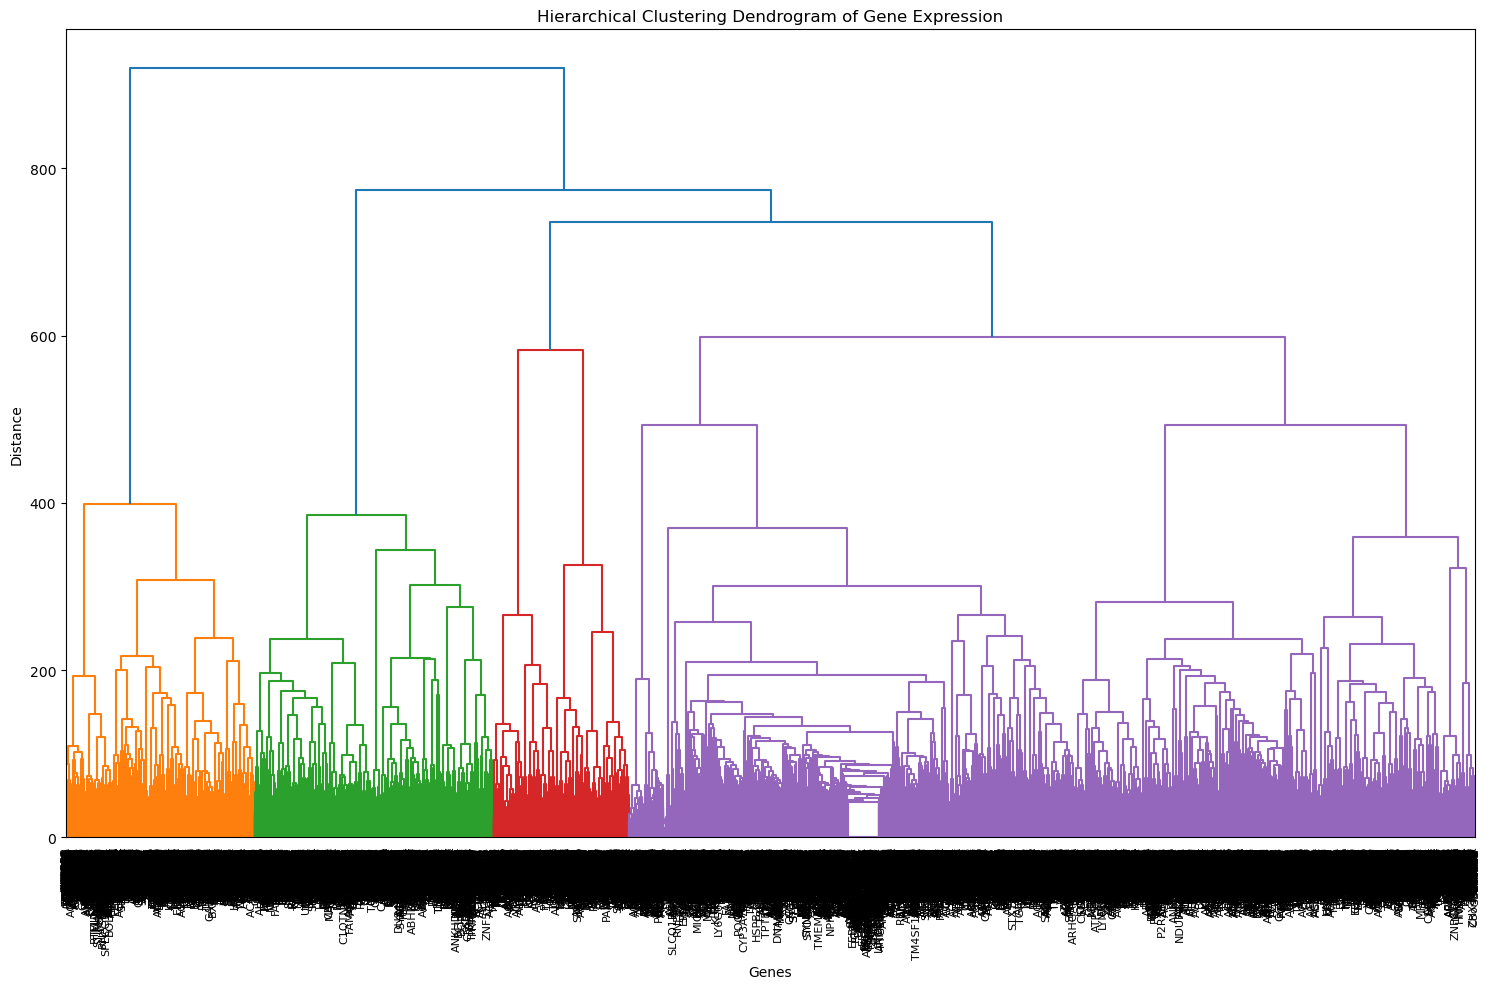

In [43]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Read the data
df = gene_expression

# Standardize the features using StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    index=df.index,
    columns=df.columns
)

# Transpose the data so genes are rows
df_transposed = df_scaled.T

# Remove any non-numeric columns if present
df_numeric = df_transposed.select_dtypes(include=[np.number])

# Perform hierarchical clustering
linkage_matrix = linkage(df_numeric, method='ward', metric='euclidean')

# Create a figure with a larger size
plt.figure(figsize=(15, 10))

# Create the dendrogram
dendrogram(linkage_matrix, 
          labels=df_numeric.index,
          leaf_rotation=90,  # rotates the x axis labels
          leaf_font_size=8)  # font size for the gene names

plt.title('Hierarchical Clustering Dendrogram of Gene Expression')
plt.xlabel('Genes')
plt.ylabel('Distance')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1500x1000 with 0 Axes>

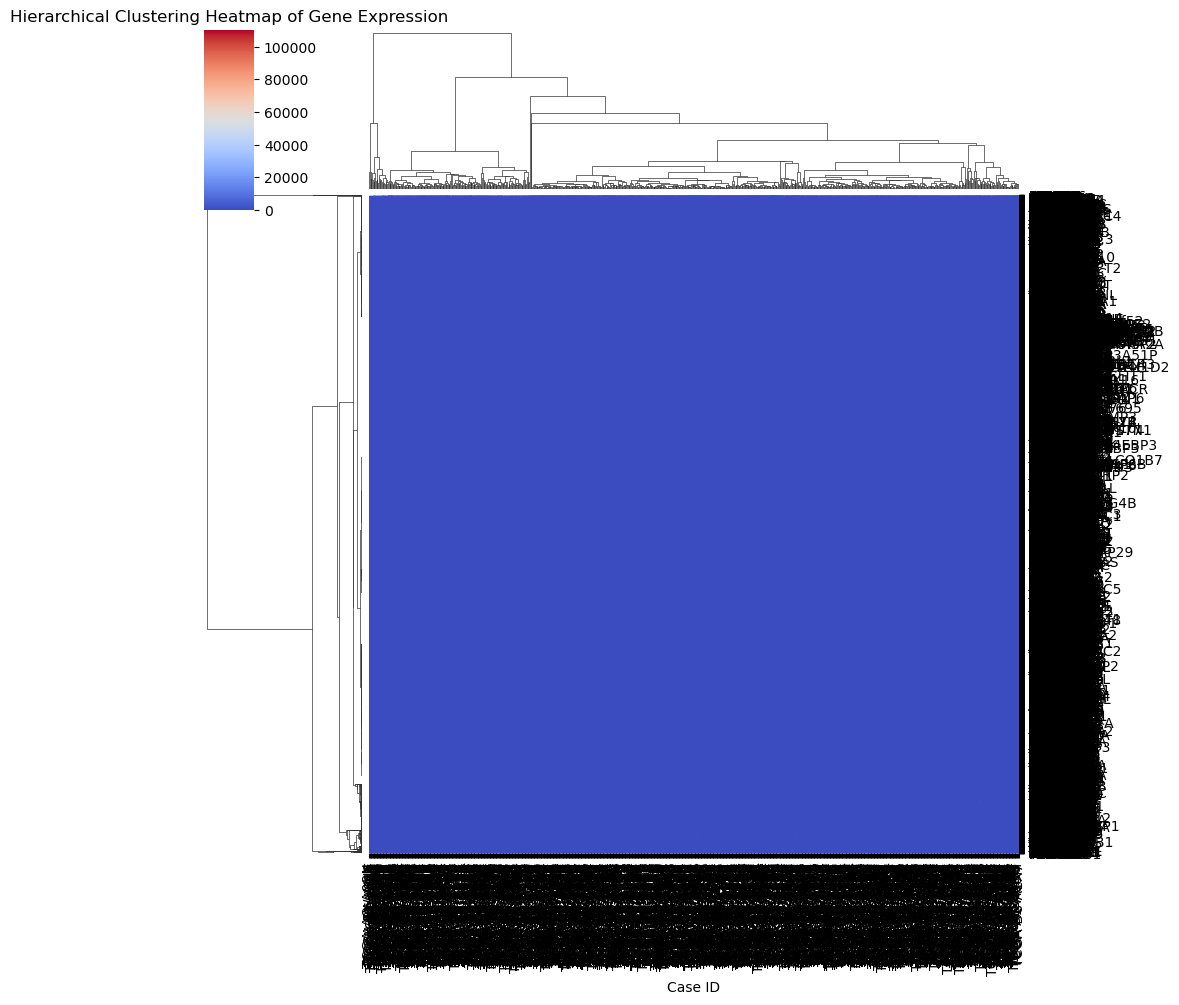

In [41]:

# Optional: Create a heatmap of the gene expression data
plt.figure(figsize=(15, 10))
sns.clustermap(df_numeric,
               method='ward',
               metric='euclidean',
               cmap='coolwarm',
               xticklabels=True,
               yticklabels=True)
plt.title('Hierarchical Clustering Heatmap of Gene Expression')
plt.show()

In [42]:
from scipy.cluster.hierarchy import fcluster

# Cut the tree to get a specific number of clusters (e.g., 5 clusters)
n_clusters = 150
clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Add cluster assignments to your dataframe
df_numeric['Cluster'] = clusters

# Print genes in each cluster
for i in range(1, n_clusters + 1):
    print(f"\nCluster {i} genes:")
    print(df_numeric[df_numeric['Cluster'] == i].index.tolist())


Cluster 1 genes:
['MT-CYB']

Cluster 2 genes:
['MT-ATP6']

Cluster 3 genes:
['MT-ND2']

Cluster 4 genes:
['MT-ND1']

Cluster 5 genes:
['MT-ND3']

Cluster 6 genes:
['MT-CO1']

Cluster 7 genes:
['MT-ND4']

Cluster 8 genes:
['MT-CO2']

Cluster 9 genes:
['MT-CO3']

Cluster 10 genes:
['TSPAN6', 'NFYA', 'TMEM176A', 'DBNDD1', 'RBM6', 'RECQL', 'PDK4', 'SLC25A13', 'CDC27', 'HCCS', 'PRSS22', 'RPAP3', 'COPZ2', 'CREBBP', 'CROT', 'KMT2E', 'IBTK', 'FBXL3', 'ITGA3', 'REX1BD', 'TMEM98', 'TMEM132A', 'ZNF263', 'CX3CL1', 'SPATA20', 'VPS41', 'ELAC2', 'PNPLA4', 'PROM1', 'PAFAH1B1', 'RPUSD1', 'RHBDF1', 'PIGQ', 'TEAD3', 'DNAJC11', 'JARID2', 'NADK', 'SPAG9', 'IL32', 'HEATR5B', 'VTA1', 'ZNF207', 'NISCH', 'CD4', 'SCMH1', 'TTC19', 'PIK3C2A', 'PLAUR', 'ANLN', 'RABGAP1', 'MAP4K3', 'ERCC1', 'SEMA3B', 'MAP4K5', 'MAN2B2', 'ZC3H3', 'XYLT2', 'WWTR1', 'AGPS', 'CXorf56', 'FHL1', 'ZDHHC6', 'NDUFS1', 'RB1CC1', 'AKAP11', 'DERA', 'DEF6', 'UBR2', 'HSF2', 'PHF20', 'NCAPH2', 'MIPEP', 'TNFRSF1B', 'VEZT', 'NUP160', 'BAK1', 'ATP6